# Priors on Transition Proba : Symptoms given Infection


For the UNVACCINATED, based on a high-quality study from Spain in early '21, we will assume that our desired prior should have the following properties:

| Param Name                 | Mean/Mode    | 20-80 interval | 02-98 interval
| -------------------------- | ------------ | -------------- | ---------------
| p(symptom &#124; infect)   | 0.760        | 0.710 - 0.810  | 0.610 - 0.910


In [1]:
ideal_props = dict(
    p50=0.760, p20=0.710, p80=0.810, p02=0.610, p98=0.910,
    w50=1.000, w20=1.000, w80=1.000, w02=1.000, w98=1.000)

## Setup

In [2]:
import numpy as np
import scipy.stats
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import viz_2d_gridsearch

In [7]:
import utils_pprint

In [8]:
import dist_beta

In [9]:
import dist_betamix

# Version 1: Simple Beta prior

Let's find the best Beta distribution that fits our constraints


At Level 0
-----------
xvar $\alpha$ grid has 10 elements
[0.001, 22.223111111111113, 44.44522222222222]
...
[155.5557777777778, 177.7778888888889, 200.0]
yvar $\beta$ grid has 10 elements
[0.001, 22.223111111111113, 44.44522222222222]
...
[155.5557777777778, 177.7778888888889, 200.0]

At Level 1
-----------
xvar $\alpha$ grid has 14 elements
[22.223111111111113, 27.3512905982906, 32.47947008547009]
...
[78.63308547008548, 83.76126495726497, 88.88944444444445]
yvar $\beta$ grid has 14 elements
[0.001, 3.4197863247863247, 6.83857264957265]
...
[37.60764957264957, 41.026435897435896, 44.44522222222222]

At Level 2
-----------
xvar $\alpha$ grid has 20 elements
[22.223111111111113, 23.0328236617184, 23.842536212325687]
...
[35.988224471435004, 36.79793702204229, 37.60764957264958]
yvar $\beta$ grid has 20 elements
[3.4197863247863247, 3.9595946918578497, 4.499403058929374]
...
[12.59652856500225, 13.136336932073775, 13.676145299145299]

At Level 3
-----------
xvar $\alpha$ grid has 28 el

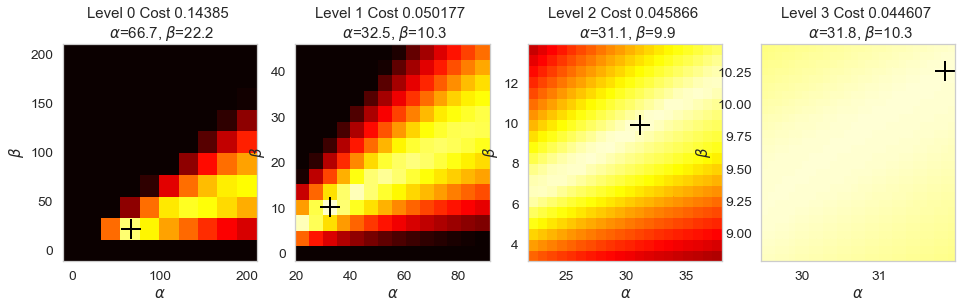

In [10]:
best_alpha, best_beta, best_cost = viz_2d_gridsearch.do_gridsearch_and_visualize(
    dist_beta.calc_cost,
    n_levels=4,
    xvar_name='$\\alpha$',
    yvar_name='$\\beta$',
    xvar_fmtstr='{:.1f}',
    yvar_fmtstr='{:.1f}',
    xvar_lims=(0.001, 200),
    yvar_lims=(0.001, 200),
    cost_kwargs=dict(random_state=0, size=100000, ideal_props=ideal_props),
    vmin=0.0,
    vmax=1.0)

In [11]:
S = 100000
samps_v1_S = dist_beta.sample(best_alpha, best_beta, size=S, random_state=1)
samps_v2_S = dist_beta.sample(best_alpha, best_beta, size=S, random_state=2)

In [12]:
df = utils_pprint.pprint_samples(samps_v1_S, samps_v2_S, ideal_props=ideal_props);

print("")
print(" Best cost: %.5f" % best_cost)
print("----------")
print(" best alpha: % 8.3f" % best_alpha)
print(" best beta : % 8.3f" % best_beta)

 perc  desired  observed1  observed2
  2.0     0.61      0.610      0.609
 20.0     0.71      0.702      0.702
 50.0     0.76      0.761      0.761
 80.0     0.81      0.813      0.813
 98.0     0.91      0.877      0.876

 Best cost: 0.04461
----------
 best alpha:   31.850
 best beta :   10.257


# Recall what a Beta(1.1, 1.1) looks like

Nearly uniform over the 0-1 interval, but just a little decay at the edges.

A priori, we do NOT think that our transition probability is extremely close to 0 or 1.

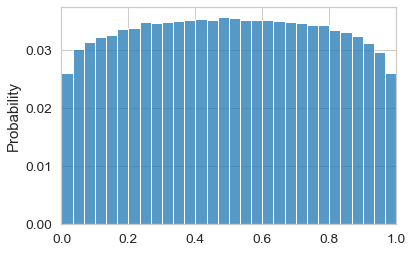

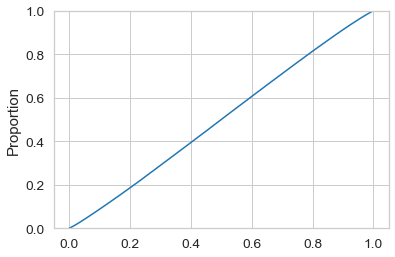

In [13]:
S = int(1e6)
m = 0.5
t = 2.2
samps_wide_S = dist_beta.sample(m * t, (1-m) * t, size=S, random_state=2)
sns.histplot(samps_wide_S, stat="probability", bins=np.linspace(0.0, 1.0, 31));
plt.xlim([0, 1])

plt.figure()
sns.ecdfplot(samps_wide_S);

# Version 2: Mixture-of-Betas prior

Try a MIXTURE of 

$$
w \cdot \text{Beta}( m * t, (1-m) *t) + (1-w) \text{Beta}(1.1, 1.1)
$$

Two free parameters:

* Total sum t (a positive scalar)
* Mixture weight w (in 0 to 1 interval)


At Level 0
-----------
xvar t grid has 10 elements
[0.1, 22.311111111111114, 44.522222222222226]
...
[155.57777777777778, 177.7888888888889, 200.0]
yvar w grid has 10 elements
[0.0001, 0.11118888888888889, 0.22227777777777777]
...
[0.7777222222222222, 0.8888111111111111, 0.9999]

At Level 1
-----------
xvar t grid has 14 elements
[0.1, 5.225641025641026, 10.351282051282052]
...
[56.48205128205129, 61.60769230769231, 66.73333333333333]
yvar w grid has 14 elements
[0.7777222222222222, 0.7948128205128205, 0.8119034188034188]
...
[0.9657188034188035, 0.9828094017094018, 0.9999]

At Level 2
-----------
xvar t grid has 20 elements
[41.10512820512821, 41.914439946018895, 42.72375168690959]
...
[54.86342780026991, 55.672739541160595, 56.48205128205129]
yvar w grid has 20 elements
[0.9486282051282051, 0.9513267206477732, 0.9540252361673415]
...
[0.9945029689608637, 0.9972014844804319, 0.9999]

At Level 3
-----------
xvar t grid has 28 elements
[51.62618083670716, 51.71610436347279, 51.80602789

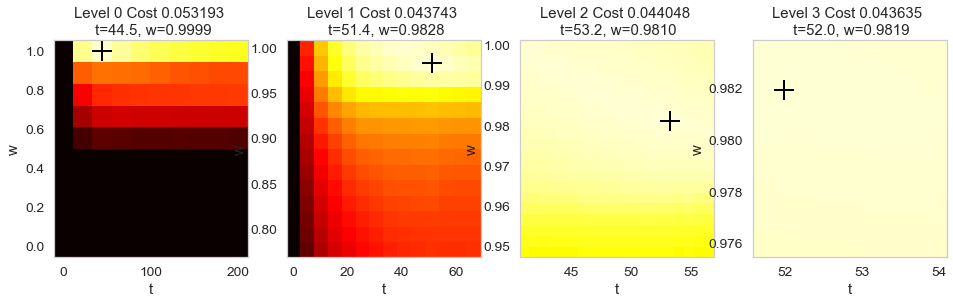

In [14]:
best_t, best_w, best_cost_betamix = viz_2d_gridsearch.do_gridsearch_and_visualize(
    dist_betamix.calc_cost,
    n_levels=4,
    xvar_name='t',
    yvar_name='w',
    xvar_fmtstr='{:.1f}',
    yvar_fmtstr='{:.4f}',
    xvar_lims=(0.1, 200),
    yvar_lims=(0.0001, 0.9999),
    cost_kwargs=dict(random_state=0, size=100000, ideal_props=ideal_props),
    vmin=0.0,
    vmax=1.0)

In [15]:
S = 100000
samps_v1_S = dist_betamix.sample(best_t, best_w, size=S, random_state=1, ideal_props=ideal_props)
samps_v2_S = dist_betamix.sample(best_t, best_w, size=S, random_state=2, ideal_props=ideal_props)

In [16]:
df = utils_pprint.pprint_samples(samps_v1_S, samps_v2_S, ideal_props=ideal_props);

print("")
print(" Best cost: %.5f" % best_cost_betamix)
print("----------")
print(" best t: % 8.3f" % best_t)
print(" best w: % 8.3f" % best_w)
print(" best m: % 8.3f" % ideal_props['p50'])

 perc  desired  observed1  observed2
  2.0     0.61      0.609      0.607
 20.0     0.71      0.709      0.709
 50.0     0.76      0.762      0.762
 80.0     0.81      0.810      0.810
 98.0     0.91      0.870      0.870

 Best cost: 0.04363
----------
 best t:   51.986
 best w:    0.982
 best m:    0.760


In [17]:
# Visual of chosen prior distribution

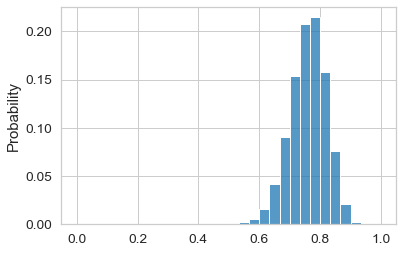

In [18]:
sns.histplot(samps_v1_S, stat="probability", bins=np.linspace(0.0, 1.0, 31));

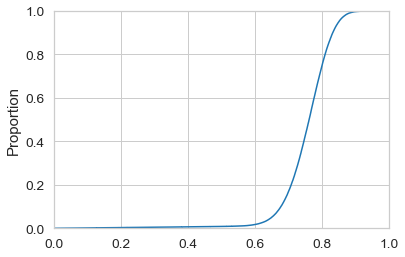

In [19]:
sns.ecdfplot(samps_v1_S);
plt.xlim([0.0, 1.0]);